# Siamese neural networks
---

Nathan L. Toner

## Introduction

Siamese networks tell whether two inputs are the same or different. That's it!

Siamese networks (problematic name) comprise two branches that each take an input and encode it into a latent space, followed by some comparison between these two encoded inputs that results in a similarity measure.

![Siamese network example](figures/siamese_structure.png)

*L. V. Utkin, M. S. Kovalev, and E. M. Kasimov, “An explanation method for Siamese neural networks,” arXiv:1911.07702 [cs, stat], Nov. 2019, Accessed: Aug. 03, 2020. [Online]. Available: http://arxiv.org/abs/1911.07702.*

The two encoders are *identical*, i.e., it's the same network on the same silicon running on each image.

Given a dataset of pairs of inputs $\mathcal{X} = \big\{(x_i, x_j), y_{ij}\big\}$ such that $y_{ij} = 1$ if $x_i$ and $x_j$ represent the same class and $y_{ij} = 0$ otherwise, we encode each input into a latent space:

$$
\begin{align}
h_i &= A\big(x_i, \theta \big) \\
h_j &= A\big(x_j, \theta \big)
\end{align}
$$

where $A(\cdot, \theta)$ is some model parameterized by $\theta$ operating on its input. We then calculate a distance measure between outputs such as the $l_1$ norm:

$$
d_{ij} = \big\lVert h_i - h_j \big\rVert_1 = \big\lVert A\big(x_i\big) - A\big(x_j\big) \big\rVert_1
$$

Finally, we define a loss function that penalizes large distance measures for similar objects (i.e., $y_{ij} = 1$), and small distance measures for dissimilar objects (i.e., $y_{ij} = 0$). Typically the "contrastive loss" function or some variation thereof is used.

$$
L(y, d) = y_{ij} d_{ij}^2 + (1 - y_{ij}) \max \big((m - d_{ij})^2, 0\big)
$$

Contrastive loss tries to push our distance measure $d \rightarrow 0$ for similar pairs of objects, and to some margin $d \rightarrow m$ (typically chosen as $m = 1$) for dissimilar objects.

And that's it! You can plug whatever algorithm you want in for $A$ as long as you can train it iteratively using something like backpropagation and the chosen loss function. The resulting network will tell you whether two inputs are similar or dissimilar, and give you an idea of *how* similar they are.

## Cool...but why?

Turns out a network trained like this works surprisingly well on never-before-seen classes drawn from a similar domain. We're going to work through an example of this with hand-written numbers.

## Set up the environment
---

In [327]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Dense, Flatten, BatchNormalization, Input,
                                     Conv2D, GlobalAveragePooling2D, LeakyReLU,
                                     Subtract)
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt

Define helper functions.

In [161]:
def l1_norm(inputs):
    u, v = inputs
    difference = tf.abs(u - v)
    return tf.reduce_mean(difference, axis=[-1])

In [143]:
def contrastive_loss(y, d):
    margin = 1.
    y = tf.cast(y, dtype=tf.float32)
    return tf.reduce_mean(y * tf.square(d) + (1. - y) * tf.square(tf.maximum(margin - d, 0.)))

In [116]:
def create_pairs(x, digit_indices, digits):
    """Positive and negative pair creation.
    
    Alternates between positive and negative pairs.
    
    """
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in digits]) - 1
    for d, idx in zip(digits, range(len(digits))):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randint(1, len(digits) - 1)
            dn = digits[(idx + inc) % len(digits)]
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [261]:
def compute_accuracy(labels, predictions):
    """Compute classification accuracy with a fixed threshold on distances."""
    pred = tf.cast(predictions < 0.5, dtype=tf.float32)
    labels = tf.cast(labels, dtype=tf.float32)
    return tf.reduce_mean(tf.metrics.binary_accuracy(labels, pred))

In [6]:
def plot_pairs(data, labels, num_pairs=10):
    """Plots MNIST data pairs."""
    fig, axes = plt.subplots(2, num_pairs,
                             figsize=(2*num_pairs, 3))
    for i in range(num_pairs):
        im = random.randint(0, len(data))
        ax = axes[0, i]
        ax.imshow(data[im][0, ..., 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax = axes[1, i]
        ax.imshow(data[im][1, ..., 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('same' if labels[im] == 1 else 'different',
                      rotation=0, labelpad=25)
    axes[0, 0].set_title('Training pairs')
    plt.tight_layout(w_pad=-60)
    plt.show()

In [7]:
def process_data(x):
    data = x.astype('float32')
    data = np.expand_dims(data, axis=-1)
    data /= 255
    return data

In [178]:
def test_network(model, data, labels, thresh=0.5):
    idx = random.randint(0, len(data)-1)
    if labels[idx] == 1:
        label = 'same'
    else:
        label = 'different'
    image_a, image_b = data[idx]
    image_a = np.expand_dims(image_a, axis=0)
    image_b = np.expand_dims(image_b, axis=0)
    result = model.predict([image_a, image_b])

    # Plot the images.
    fig, axes = plt.subplots(1, 2,
                             figsize=(6, 3))
    for i in range(2):
        ax = axes[i]
        ax.imshow(data[idx, i, ..., 0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

    # Print the results of the network.
    print(f'Distance output: {result}')
    if result < thresh:
        pred = 'same'
    else:
        pred = 'different'
    print(f'True label: {label}')
    print(f'Predicted label: {pred}')

## Import data and create data pairs
---

Load and pre-process the data.

In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = process_data(X_train)
X_test = process_data(X_test)
in_dim = X_train.shape[-3:]

Plot some of the image pool.

In [10]:
num_row = 2
num_col = 5

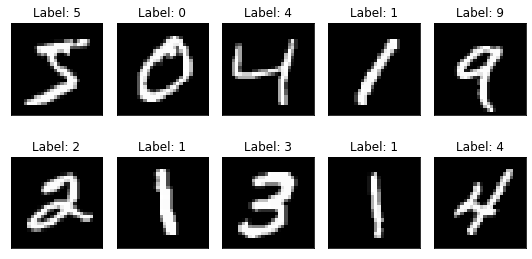

In [11]:
fig, axes = plt.subplots(num_row, num_col,
                         figsize=(1.5*num_col, 2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[i, ..., 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

Create training and testing positive and negative pairs.

Here we select which numbers are seen during training vs. which are seen during testing. We can have as much or as little overlap as we want, so for instance training and testing could use all available digits, or we could divide digits up so only even numbers are seen in training and odd numbers seen in testing. The latter case allows us to see how well the network generalizes to never-before-seen classes drawn from the same domain (handwritten digits).

In [132]:
digit_indices = np.array([np.where(y_train == i)[0] for i in range(10)])
digits = [1, 3, 5, 7, 9]  # odd numbers only in training
tr_pairs, tr_y = create_pairs(X_train, digit_indices, digits)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
digits = [0, 2, 4, 6, 8]  # even numbers only in testing
te_pairs, te_y = create_pairs(X_test, digit_indices, digits)

Plot some examples of pairs.

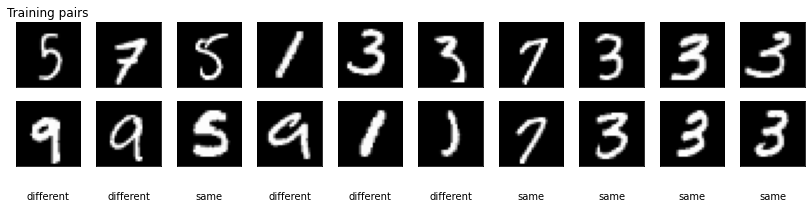

In [133]:
plot_pairs(tr_pairs, tr_y)

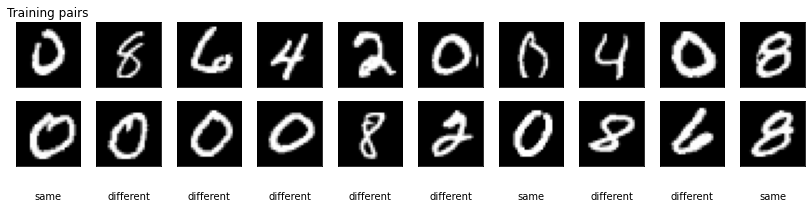

In [134]:
plot_pairs(te_pairs, te_y)

## Train the network
---

First we define the network. Remember, *this can be **anything** we can train!*

We will make a convolutional neural network with three layers and skip connections. Each layer uses batch normalization, convolution, and then a leaky-ReLU activation before the result of the activation is added back to the layer's input.

![Convolutional network structure](figures/conv_net.png)

In [285]:
num_filters = 8

def create_base_net(input_dim):
    x_in = Input(shape=input_dim)
    
    # First block.
    x = BatchNormalization()(x_in)
    x = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(x)
    h_1 = x + x_in
    
    # Second block.
    x = BatchNormalization()(h_1)
    x = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(x)
    h_2 = x + h_1
    
    # Third block.
    x = BatchNormalization()(h_2)
    x = Conv2D(1, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(x)
    h_3 = x + Conv2D(1, kernel_size=(1, 1), padding='same')(h_2)
    
    # Output block.
    x = Flatten()(h_3)
    x = Dense(20)(x)
    out = tf.math.sigmoid(x)
    return Model(inputs=x_in, outputs=out, name='base_model')

Next we create the base model and then put together the overarching network architecture, i.e., we want two copies of the base network, each taking a different input, and feeding into our distance measure.

![Siamese network architecture](figures/siamse_net.png)

So first we create the base model...

In [286]:
base_model = create_base_net(in_dim)
base_model.summary()

Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 28, 28, 1)    4           input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 28, 28, 8)    80          batch_normalization_40[0][0]     
__________________________________________________________________________________________________
leaky_re_lu_35 (LeakyReLU)      (None, 28, 28, 8)    0           conv2d_43[0][0]                  
_________________________________________________________________________________________

Next we create inputs for each side of the network. These are basically just placeholders so TensorFlow knows where our inputs go later.

In [287]:
input_a = Input(shape=in_dim, name='input_a')
input_b = Input(shape=in_dim, name='input_b')

We pass each input through the *same* base model.

In [288]:
output_a = base_model(input_a)
output_b = base_model(input_b)

Finally we calculate a distance measure between the encoded inputs.

In [289]:
distance = l1_norm([output_a, output_b])

Compile the model so that it accepts two inputs and returns the distance measure between them.

In [290]:
model = Model(inputs=[input_a, input_b],
              outputs=distance,
              name='siamese_model')
model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
base_model (Model)              (None, 20)           16514       input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_7 (TensorFlowOp [(None, 20)]         0           base_model[1][0]     

Before we train, we have to tell TensorFlow/Keras what optimizer we are using, what loss function we are minimizing (or maximizing), and what if any metrics we want to report back.

In [291]:
model.compile(loss=contrastive_loss,
              optimizer='adam',
              metrics=[compute_accuracy])

Train the model on our data and test.

In [293]:
model.fit(x=[tr_pairs[:, 0], tr_pairs[:, 1]],
          y=tr_y,
          batch_size=128,
          epochs=20,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 54200 samples, validate on 9570 samples
Epoch 1/20
54200/54200 [==============================] - 34s 620us/sample - loss: 0.0901 - compute_accuracy: 0.9275 - val_loss: 0.1930 - val_compute_accuracy: 0.7082
Epoch 2/20
54200/54200 [==============================] - 34s 618us/sample - loss: 0.0898 - compute_accuracy: 0.9275 - val_loss: 0.1917 - val_compute_accuracy: 0.7102
Epoch 3/20
54200/54200 [==============================] - 33s 617us/sample - loss: 0.0895 - compute_accuracy: 0.9307 - val_loss: 0.1933 - val_compute_accuracy: 0.7069
Epoch 4/20
54200/54200 [==============================] - 34s 623us/sample - loss: 0.0893 - compute_accuracy: 0.9299 - val_loss: 0.1944 - val_compute_accuracy: 0.7076
Epoch 5/20
54200/54200 [==============================] - 34s 619us/sample - loss: 0.0890 - compute_accuracy: 0.9319 - val_loss: 0.1947 - val_compute_accuracy: 0.7082
Epoch 6/20
54200/54200 [==============================] - 33s 613us/sample - loss: 0.0889 - compute_accuracy: 0.9326

Save/load the model.

In [325]:
model.save('model/siamese_net.h5')

In [330]:
model = load_model('model/siamese_net.h5',
                   custom_objects={
                       'contrastive_loss': contrastive_loss,
                       'compute_accuracy': compute_accuracy})

## Demonstration of the trained model
---

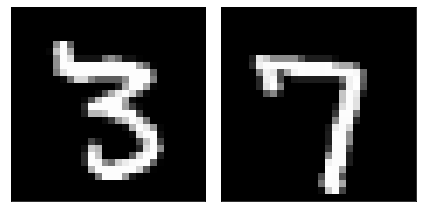

Distance output: [0.5997888]
True label: different
Predicted label: different


In [333]:
test_network(model, tr_pairs, tr_y)

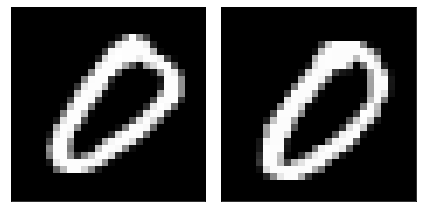

Distance output: [0.00012547]
True label: same
Predicted label: same


In [336]:
test_network(model, te_pairs, te_y)

## Analyze the trained model
---

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

In [257]:
predictions = model.predict([te_pairs[:, 0], te_pairs[:, 1]])

In [258]:
fpr, tpr, thresholds = roc_curve(te_y, predictions)

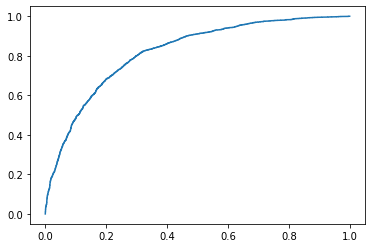

In [260]:
plt.plot(tpr, fpr)